In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
import json
from tqdm import tqdm  #   For progress bars
from typing import List, Dict, Tuple





NUM_HYPERBOLE_LABLES = 2

NUM_SENTIMENT_ANALYSIS_LABELS = 6





BERT_MODEL_NAME = "bert-base-uncased"

MAX_LEN = 512

BATCH_SIZE = 10

EPOCHS = 5

LEARNING_RATE = 2e-5
DATASET_SIZE = 1000

In [ ]:
#   1. Data Loading and Preprocessing
def load_data(file_paths):
    """Loads data from JSON files."""
    data = []
    for file_path in file_paths:
        with open(file_path, "r") as f:
            data.append(json.load(f))
    return data

def create_multilabels(tokens: Dict[str, Dict]) -> Dict[str, List[int]]:
    """
    Creates multi-labels for each token, handling missing labels.
    """
    multi_labels = {}
    for token, annotations in tokens.items():
        hyperbole = annotations.get("model_Hyperbole", -100)  #   Use .get() with default
        sentiment = annotations.get("model_Sentiment Analysis", -100)
        multi_labels[token] = [hyperbole, sentiment]
    return multi_labels

def align_labels_with_tokens(
    tokens: List[str], labels: List[List[int]], tokenizer: BertTokenizer
) -> Tuple[List[str], List[List[int]], List[int]]:
    """
    Aligns labels with sub-word tokens produced by the BERT tokenizer.
    Assigns the same label to all sub-words of a token.
    """

    aligned_tokens = []
    aligned_labels = []
    token_masks = []

    for i, token in enumerate(tokens):
        subword_tokens = tokenizer.tokenize(
            token
        )  #   Important: No add_prefix_space here
        token_labels = labels[i]
        aligned_tokens.extend(subword_tokens)
        aligned_labels.extend([token_labels] * len(subword_tokens))  #   Repeat labels
        token_masks.extend([1] * len(subword_tokens))  # 1 for real tokens

    return aligned_tokens, aligned_labels, token_masks

def preprocess_data(
    data: List[Dict], tokenizer: BertTokenizer, max_len: int
) -> List[Dict]:
    """
    Preprocesses the data, extracting tokens, text, and creating multi-labels.
    Truncates texts to max_len tokens *after* sub-word tokenization.
    """

    processed_data = []
    for item in data:
        text = " ".join(item["tokens"].keys())
        tokens = list(item["tokens"].keys())
        labels = list(create_multilabels(item["tokens"]).values())

        aligned_tokens, aligned_labels, token_masks = align_labels_with_tokens(
            tokens, labels, tokenizer
        )

        #   Truncate *aligned* tokens and labels if they exceed max_len
        if len(aligned_tokens) > max_len:
            aligned_tokens = aligned_tokens[:max_len]
            aligned_labels = aligned_labels[:max_len]
            token_masks = token_masks[:max_len]
            text = tokenizer.decode(
                tokenizer.convert_tokens_to_ids(aligned_tokens)
            )  #   Reconstruct text (approximate)

        processed_data.append(
            {
                "text": text,
                "tokens": aligned_tokens,
                "labels": aligned_labels,
                "token_masks": token_masks,
            }
        )
    return processed_data

class TokenDataset(Dataset):
    """Dataset for token classification."""

    def __init__(self, texts, labels, tokenizer, max_len, token_masks):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len  # Store max_len
        self.token_masks = token_masks

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        labels = self.labels[item]
        token_mask = self.token_masks[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,  # Use self.max_len
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        padded_labels = torch.full(
            (self.max_len, 2), -100, dtype=torch.long  # Use self.max_len
        )
        padded_labels[: len(labels), :] = torch.tensor(labels, dtype=torch.long)

        padded_mask = torch.zeros(self.max_len, dtype=torch.long)  # Use self.max_len
        padded_mask[: len(token_mask)] = torch.tensor(
            token_mask, dtype=torch.long
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": padded_labels,
            "token_mask": padded_mask,
        }

class MultiLabelBERT_Sentiment(torch.nn.Module):
    """BERT model for multi-label token classification."""

    def __init__(
        self,
        bert_model_name,
        num_hyperbol_labels,
        num_sentiment_labels
    ):
        super(MultiLabelBERT_Sentiment, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hyperbole_classifier = torch.nn.Linear(
            self.bert.config.hidden_size, num_hyperbol_labels
        )
        self.sentiment_classifier = torch.nn.Linear(
            self.bert.config.hidden_size, num_sentiment_labels
        )
        

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = (
            outputs.last_hidden_state
        )  # (batch_size, max_len, hidden_size)

        hyperbole_logits = self.hyperbole_classifier(sequence_output)
        sentiment_logits = self.sentiment_classifier(sequence_output)

        return hyperbole_logits, sentiment_logits

In [3]:
def train(
    model, train_dataloader, val_dataloader, optimizer, scheduler, device, epochs
):
    """Trains the model."""

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch_idx, batch in enumerate(
            tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        ):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)  # Shape: (batch_size, max_len, 2)
            token_mask = batch["token_mask"].to(device)  # Shape: (batch_size, max_len)

            batch_size = input_ids.shape[0]

            assert labels.shape == (batch_size, MAX_LEN, 2)
            assert token_mask.shape == (batch_size, MAX_LEN)

            model.zero_grad()
            outputs = model(input_ids, attention_mask)  # Get the raw model output
            hyperbole_logits, sentiment_logits = (
                outputs[0],
                outputs[1]
            )  # If your model returns a tuple

            hyperbole_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
            sentiment_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)

            #   Apply token mask to filter predictions and labels
            #   Crucially, we flatten *before* applying the mask
            active_hyperbole_logits = hyperbole_logits.view(
                -1, NUM_HYPERBOLE_LABLES
            )  # Shape: (batch_size * max_len, num_labels)
            active_sentiment_logits = sentiment_logits.view(
                -1, NUM_SENTIMENT_ANALYSIS_LABELS
            )

            active_labels_hyperbole = labels[:, :, 0].reshape(
                -1
            )  # Shape: (batch_size * max_len,)
            active_labels_sentiment = labels[:, :, 1].reshape(-1)

            assert active_hyperbole_logits.shape[0] == batch_size * MAX_LEN
            assert active_labels_hyperbole.shape[0] == batch_size * MAX_LEN

            #   Apply the mask *after* flattening
            #   CRUCIAL CHANGE: Adjust mask for [CLS] token
            active_indices = torch.where(token_mask.view(-1) == 1)[
                0
            ]  # Get indices of valid tokens
            active_hyperbole_logits = active_hyperbole_logits[active_indices]
            active_sentiment_logits = active_sentiment_logits[active_indices]

            active_labels_hyperbole = active_labels_hyperbole[active_indices]
            active_labels_sentiment = active_labels_sentiment[active_indices]

            #   Check shapes *right before* loss
            assert active_hyperbole_logits.shape[0] == active_labels_hyperbole.shape[0]

            hyperbole_loss = hyperbole_loss_fn(active_hyperbole_logits, active_labels_hyperbole)
            sentiment_loss = sentiment_loss_fn(
                active_sentiment_logits, active_labels_sentiment
            )
            

            loss = hyperbole_loss + sentiment_loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"  Average training loss: {avg_train_loss}")

        #   Validation (Simplified - No metrics here)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                token_mask = batch["token_mask"].to(device)

                batch_size = input_ids.shape[0]

                assert labels.shape == (batch_size, MAX_LEN, 2)
                assert token_mask.shape == (batch_size, MAX_LEN)

                outputs = model(input_ids, attention_mask)  # Get the raw model output
                hyperbole_logits, sentiment_logits = (
                    outputs[0],
                    outputs[1],
                )  # If your model returns a tuple

                # Apply token mask in validation too!
                active_indices = torch.where(token_mask.view(-1) == 1)[
                    0
                ]  # Get indices of valid tokens

                active_hyperbole_logits = hyperbole_logits.view(-1, NUM_HYPERBOLE_LABLES)[
                    active_indices
                ]
                active_sentiment_logits = sentiment_logits.view(
                    -1, NUM_SENTIMENT_ANALYSIS_LABELS
                )[active_indices]

                active_labels_hyperbole = labels[:, :, 0].reshape(-1)[active_indices]
                active_labels_sentiment = labels[:, :, 1].reshape(-1)[
                    active_indices
                ]

                # Check shapes *right before* loss
                assert active_hyperbole_logits.shape[0] == active_labels_hyperbole.shape[0]

                hyperbole_loss = hyperbole_loss_fn(active_hyperbole_logits, active_labels_hyperbole)
                sentiment_loss = sentiment_loss_fn(
                    active_sentiment_logits, active_labels_sentiment
                )

                loss = hyperbole_loss + sentiment_loss
                total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_dataloader)
            print(f"  Average validation loss: {avg_val_loss}")

In [4]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [5]:
# pad file number to 6 digits
file_paths = [f"dataset/article_{i:06d}.json" for i in range(DATASET_SIZE)]
data = load_data(file_paths)
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
processed_data = preprocess_data(data, tokenizer=tokenizer, max_len=MAX_LEN)

In [6]:
train_data, val_data = train_test_split(processed_data, test_size=0.2, random_state=42)

In [7]:
#   Create Datasets and DataLoaders
train_dataset = TokenDataset(
    texts=[item["text"] for item in train_data],
    labels=[item["labels"] for item in train_data],
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    token_masks=[item["token_masks"] for item in train_data],
)
val_dataset = TokenDataset(
    texts=[item["text"] for item in val_data],
    labels=[item["labels"] for item in val_data],
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    token_masks=[item["token_masks"] for item in val_data],
)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [9]:
#   Initialize Model, Optimizer, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelBERT_Sentiment(
    BERT_MODEL_NAME,
    NUM_HYPERBOLE_LABLES,
    NUM_SENTIMENT_ANALYSIS_LABELS,
).to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

c:\Users\rishi\.conda\envs\machine-learning\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
#   Train the Model
train(model, train_dataloader, val_dataloader, optimizer, scheduler, device, EPOCHS)

Epoch 1: 100%|██████████| 80/80 [10:46<00:00,  8.09s/it]


  Average training loss: 2.35170539021492
  Average validation loss: 2.3194031953811645


Epoch 2: 100%|██████████| 80/80 [10:50<00:00,  8.14s/it]


  Average training loss: 2.313811469078064
  Average validation loss: 2.319081974029541


Epoch 3: 100%|██████████| 80/80 [10:49<00:00,  8.12s/it]


  Average training loss: 2.3044605940580367
  Average validation loss: 2.318850815296173


Epoch 4: 100%|██████████| 80/80 [10:48<00:00,  8.10s/it]


  Average training loss: 2.286860817670822
  Average validation loss: 2.308656406402588


Epoch 5: 100%|██████████| 80/80 [10:48<00:00,  8.10s/it]


  Average training loss: 2.2685953855514525
  Average validation loss: 2.318317186832428


In [10]:
model_path = "group_2_model.pth"

In [11]:
# save the torch model
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to group_2_model.pth


In [11]:
# load model from file
model = MultiLabelBERT_Sentiment(
    BERT_MODEL_NAME,
    NUM_HYPERBOLE_LABLES,
    NUM_SENTIMENT_ANALYSIS_LABELS,
).to(device)
model.load_state_dict(torch.load(model_path))

C:\Users\rishi\AppData\Local\Temp\ipykernel_35136\1166673028.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [22]:
# evaluate the model
model.eval()
total_val_loss = 0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        token_mask = batch["token_mask"].to(device)

        outputs = model(input_ids, attention_mask)
        hyperbole_logits, sentiment_logits = outputs

        #   Apply token mask in evaluation too!
        active_indices = torch.where(token_mask.view(-1) == 1)[0]  # Get indices of valid tokens

        active_hyperbole_logits = hyperbole_logits.view(-1, NUM_HYPERBOLE_LABLES)[active_indices]
        active_sentiment_logits = sentiment_logits.view(-1, NUM_SENTIMENT_ANALYSIS_LABELS)[active_indices]

        active_labels_hyperbole = labels[:, :, 0].reshape(-1)[active_indices]
        active_labels_sentiment = labels[:, :, 1].reshape(-1)[active_indices]

        #   Check shapes *right before* loss
        assert active_hyperbole_logits.shape[0] == active_labels_hyperbole.shape[0]

        hyperbole_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
        sentiment_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)

        hyperbole_loss = hyperbole_loss_fn(active_hyperbole_logits, active_labels_hyperbole)
        sentiment_loss = sentiment_loss_fn(active_sentiment_logits, active_labels_sentiment)

        loss = hyperbole_loss + sentiment_loss
        total_val_loss += loss.item()

        #   Get predictions
        hyperbole_preds = torch.argmax(active_hyperbole_logits, dim=1)
        sentiment_preds = torch.argmax(active_sentiment_logits, dim=1)

  Average validation loss: 2.318317186832428
  Hyperbole Accuracy: 0.452991452991453
  Sentiment Accuracy: 0.21996557659208263


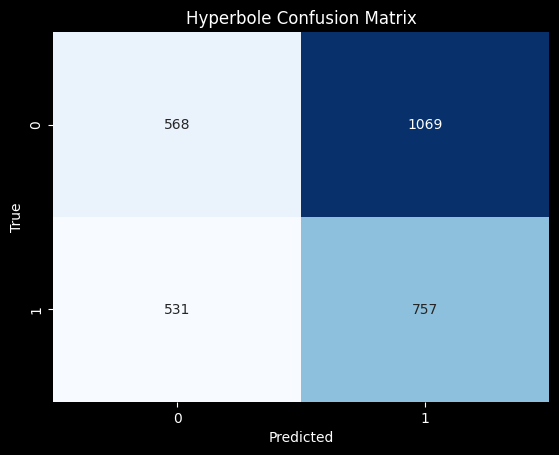

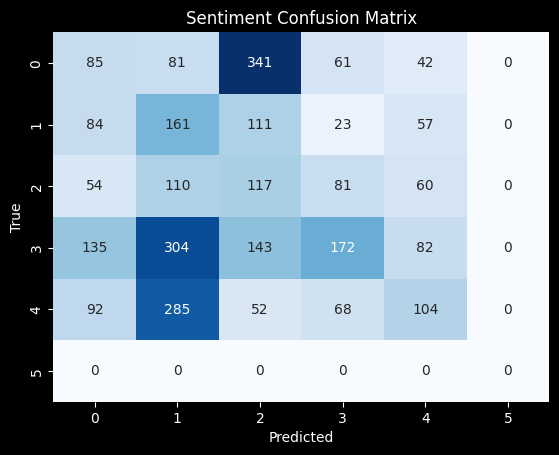

In [23]:
# mask out -100 labels for accuracy calculation
sentiment_mask = active_labels_sentiment != -100
hyperbole_mask = active_labels_hyperbole != -100
sentiment_preds = sentiment_preds[sentiment_mask]
sentiment_true_labels = active_labels_sentiment[sentiment_mask]
hyperbole_preds = hyperbole_preds[hyperbole_mask]
hyperbole_true_labels = active_labels_hyperbole[hyperbole_mask]
sentiment_accuracy = (sentiment_preds == sentiment_true_labels).sum().item() / len(
    sentiment_true_labels
)
hyperbole_accuracy = (hyperbole_preds == hyperbole_true_labels).sum().item() / len(
    hyperbole_true_labels
)
avg_val_loss = total_val_loss / len(val_dataloader)
print(f"  Average validation loss: {avg_val_loss}")

# confusion matrix
cm_hyperbole = confusion_matrix(
    hyperbole_true_labels.cpu().numpy(), hyperbole_preds.cpu().numpy(), labels=[0, 1]
)
cm_sentiment = confusion_matrix(
    sentiment_true_labels.cpu().numpy(),
    sentiment_preds.cpu().numpy(),
    labels=[0, 1, 2, 3, 4, 5],
)
sns.heatmap(
    cm_hyperbole, annot=True, fmt="d", cmap="Blues", cbar=False
)
plt.title("Hyperbole Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

sns.heatmap(
    cm_sentiment, annot=True, fmt="d", cmap="Blues", cbar=False
)
plt.title("Sentiment Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()